In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

%matplotlib inline

In [235]:
!iconv -f cp1251 -t utf-8 vk_feed.csv -o vk_feed_utf.csv 

iconv: cannot open input file `vk_feed.csv': No such file or directory


In [236]:
data = pd.read_csv('cleaned_data.csv', index_col=0)
data.head()

,text,status,predict_proba,predict,lang
0,ребят краснодар нужны доноры положительная для...,1,1,True,ru
1,волгоград прошу максимальный перепост предыдущ...,1,1,True,ru
2,срочно требуются доноры крови любая цельная кр...,1,1,True,ru
4,анонимно люди крик о помощи срочно а точнее в ...,1,1,True,ru
5,люди крик о помощи срочно а точнее в понедельн...,1,1,True,ru


In [237]:
from langdetect import detect

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return '-'

In [238]:
#data['lang']= data['text'].apply(lambda x: detect_language(x))
#data.head()

In [239]:
data.groupby(by='lang').count()

,text,status,predict_proba,predict
lang,,,,
ru,26108,26108,26108,26108


In [240]:
data = data[data['lang'] == 'ru']

In [241]:
data.groupby(by='status').count()

,text,predict_proba,predict,lang
status,,,,
0,1838,1838,1838,1838
1,24270,24270,24270,24270


In [303]:
import re
from html2text import html2text

def preprocess(text):
    text = html2text(text)
    text = re.sub('[\W]', ' ', text)
    text = re.sub('_', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('[A-Za-z0-9]', '', text) #removing english
    text = text.lower()
    return text

In [304]:
data['text'] = data['text'].apply(preprocess)

In [305]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer

class Preprocessor:
    def __init__(self, stemmer, analyser):
        self.stemmer = stemmer
        self.analyser = analyser
        
    def __call__(self, doc):
        return (self.stemmer.stem(w) for w in self.analyser(doc) if len(w) > 3)
    
preporcessor = Preprocessor(RussianStemmer(), CountVectorizer(ngram_range=(1,3)).build_analyzer())

vectorizer = CountVectorizer(stop_words=stopwords.words('russian'), analyzer=preporcessor)
V = vectorizer.fit_transform(data['text'])

print(V.shape)

(26108, 557793)


In [324]:
X = V
y = data['status']

In [322]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

kfold = StratifiedKFold(y, n_folds=4, shuffle=True)

for train_index, test_index in kfold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = MultinomialNB()
    model.fit(X_train, y_train)
    print(model.score(X_test, y_test))

TypeError: only integer arrays with one element can be converted to an index

In [325]:
model.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [326]:
model.score(X, y)

0.996629385628926

In [313]:
from collections import namedtuple

Feature = namedtuple('Feature', ['word', 'weight'])
word_dict = {}

for key, value in vectorizer.vocabulary_.items():
    word_dict[value] = Feature(key, model.coef_[0][value])

In [293]:
feature_values = list(word_dict.values())
feature_values.sort(key=lambda x: x.weight, reverse=True)
feature_values[:100]

[Feature(word='кров', weight=-4.0573687612639882),
 Feature(word='нужн', weight=-4.2801885065018483),
 Feature(word='срочн', weight=-4.3985958338801439),
 Feature(word='групп', weight=-4.6104997009582025),
 Feature(word='донор', weight=-4.6587437647053962),
 Feature(word='отрицательн', weight=-4.9339431916588401),
 Feature(word='помощ', weight=-5.0349698966569525),
 Feature(word='пожалуйст', weight=-5.0750081033665975),
 Feature(word='друз', weight=-5.1076362841449816),
 Feature(word='очен', weight=-5.1415375671885455),
 Feature(word='помог', weight=-5.1856337083440858),
 Feature(word='переливан', weight=-5.2237926640223664),
 Feature(word='может', weight=-5.2553955473543601),
 Feature(word='треб', weight=-5.2565406086395896),
 Feature(word='сдат', weight=-5.26324928134754),
 Feature(word='люб', weight=-5.264826004873675),
 Feature(word='положительн', weight=-5.4225741349358563),
 Feature(word='помоч', weight=-5.4344558316958924),
 Feature(word='репост', weight=-5.4521738128269224),
 F

In [327]:
predict_proba = list(map(lambda x: x[1], model.predict_proba(X)))
data['predict_proba'] = predict_proba

In [328]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_true = data['status']
fpr, tpr, thresholds = roc_curve(y_true, predict_proba)
auc_score = auc(fpr, tpr)

In [329]:
def plot_roc(fpr, tpr, auc_score):
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 0.5])
    plt.ylim([0.5, 1.0])
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC Curve. AUC = {0:.2f}'.format(auc_score))
    plt.show()

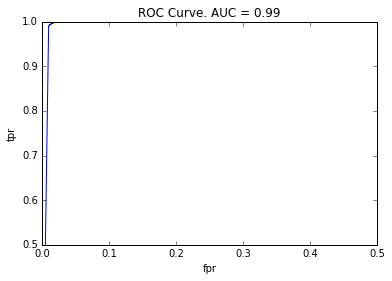

In [330]:
plot_roc(fpr, tpr, auc_score)

In [331]:
from sklearn.metrics import precision_recall_curve

precision, recall, pcrt = precision_recall_curve(y_true, predict_proba)
pcrt = np.insert(pcrt, 0, 0)

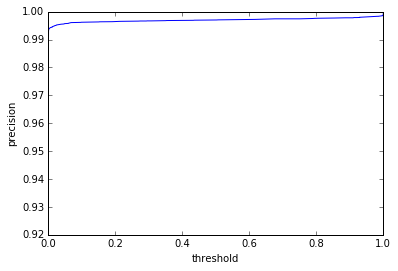

In [332]:
plt.figure()
plt.plot(pcrt, precision)
plt.xlabel('threshold')
plt.ylabel('precision')

(0.9, 1.0)

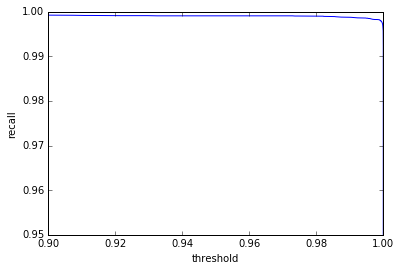

In [333]:
plt.figure()
plt.plot(pcrt, recall)
plt.xlabel('threshold')
plt.ylabel('recall')
plt.ylim([0.95, 1.0])
plt.xlim([0.90, 1.0])

In [334]:
positive_prior = model.class_count_[1] / sum(model.class_count_)
print(positive_prior)

0.929600122568


In [335]:
data['predict'] = data['predict_proba'] > positive_prior
data.to_csv('cleaned_data.csv')

In [336]:
false_negative = data[~data['predict'] & (data['status'] == 1)]
false_negative

,text,status,predict_proba,predict,lang
2733,были сегодня в биоконтроле тимошу тошнило бабу...,1,4.843399e-08,False,ru
5077,москва мо для противовирусной терапии котятам ...,1,9.214664e-01,False,ru
8037,представьте что завтра вы можете спасти чью то...,1,2.919623e-01,False,ru
13193,нужна же кровь девочке вот мне написали по ссы...,1,9.659473e-02,False,ru
15817,донорство крови что нужно знать,1,3.069744e-01,False,ru
16705,две недели назад коллега написал смс что его б...,1,2.970216e-27,False,ru
18465,поможем ванечке одолеть рак,1,9.102617e-01,False,ru
23854,аре требуется ещё кровь лежит в мск в гауз мнп...,1,5.516382e-08,False,ru
26131,срочно нужна машина на завтра чтобы в забрать ...,1,1.658520e-02,False,ru
26671,уважаемые участники группы очень просим финанс...,1,3.618974e-25,False,ru


In [337]:
false_positive = data[data['predict'] & (data['status'] == 0)]
false_positive

,text,status,predict_proba,predict,lang
14394,нужна помощь нухотьчтотохорошее,0,0.956173,True,ru
20560,подпишите петицию не оставайтесь равнодушными,0,0.998173,True,ru
20598,срочно нужна кровь срочно,0,1.000000,True,ru
21814,в наличии,0,0.949510,True,ru
30201,в наличии,0,0.949510,True,ru
32347,ростовнадону помогите спасти жизнь необходимы ...,0,1.000000,True,ru
32353,в наличии,0,0.949510,True,ru
32358,москва помогите спасти жизни срочно нужны доно...,0,1.000000,True,ru
32475,срочно требуется донор почки группа крови опла...,0,0.999998,True,ru
32565,нужно больше крови,0,0.990180,True,ru


In [338]:
from sklearn.externals import joblib

joblib.dump(vectorizer, 'model/bayes/vectorizer.pkl')
joblib.dump(model, 'model/bayes/model.pkl')

PicklingError: Can't pickle <function VectorizerMixin.build_analyzer.<locals>.<lambda> at 0x7f01d99b6598>: it's not found as sklearn.feature_extraction.text.VectorizerMixin.build_analyzer.<locals>.<lambda>